# knn classification on wisc data set

Based on https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/, updated some deprecation warnings along the way

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
wbcd = pd.read_csv('wisc_bc_data.csv')

wbcd.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,points_mean,symmetry_mean,dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,points_se,symmetry_se,dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,points_worst,symmetry_worst,dimension_worst
0,87139402,B,12.32,12.39,78.85,464.1,0.10280,0.06981,0.03987,0.03700,0.1959,0.05955,0.2360,0.6656,1.670,17.43,0.008045,0.011800,0.01683,0.012410,0.01924,0.002248,13.50,15.64,86.97,549.1,0.1385,0.1266,0.12420,0.09391,0.2827,0.06771
1,8910251,B,10.60,18.95,69.28,346.4,0.09688,0.11470,0.06387,0.02642,0.1922,0.06491,0.4505,1.1970,3.430,27.10,0.007470,0.035810,0.03354,0.013650,0.03504,0.003318,11.88,22.94,78.28,424.8,0.1213,0.2515,0.19160,0.07926,0.2940,0.07587
2,905520,B,11.04,16.83,70.92,373.2,0.10770,0.07804,0.03046,0.02480,0.1714,0.06340,0.1967,1.3870,1.342,13.54,0.005158,0.009355,0.01056,0.007483,0.01718,0.002198,12.41,26.44,79.93,471.4,0.1369,0.1482,0.10670,0.07431,0.2998,0.07881
3,868871,B,11.28,13.39,73.00,384.8,0.11640,0.11360,0.04635,0.04796,0.1771,0.06072,0.3384,1.3430,1.851,26.33,0.011270,0.034980,0.02187,0.019650,0.01580,0.003442,11.92,15.77,76.53,434.0,0.1367,0.1822,0.08669,0.08611,0.2102,0.06784
4,9012568,B,15.19,13.21,97.65,711.8,0.07963,0.06934,0.03393,0.02657,0.1721,0.05544,0.1783,0.4125,1.338,17.72,0.005012,0.014850,0.01551,0.009155,0.01647,0.001767,16.20,15.73,104.50,819.1,0.1126,0.1737,0.13620,0.08178,0.2487,0.06766


## Perform some data cleaning

In [3]:
# Cast diagnosis as category dtype
wbcd['diagnosis'] = wbcd.diagnosis.astype('category')

# Delete the id column since it's not used in our model
del wbcd['id']

print(wbcd.dtypes)
wbcd.head()

diagnosis            category
radius_mean           float64
texture_mean          float64
perimeter_mean        float64
area_mean             float64
smoothness_mean       float64
compactness_mean      float64
concavity_mean        float64
points_mean           float64
symmetry_mean         float64
dimension_mean        float64
radius_se             float64
texture_se            float64
perimeter_se          float64
area_se               float64
smoothness_se         float64
compactness_se        float64
concavity_se          float64
points_se             float64
symmetry_se           float64
dimension_se          float64
radius_worst          float64
texture_worst         float64
perimeter_worst       float64
area_worst            float64
smoothness_worst      float64
compactness_worst     float64
concavity_worst       float64
points_worst          float64
symmetry_worst        float64
dimension_worst       float64
dtype: object


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,points_mean,symmetry_mean,dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,points_se,symmetry_se,dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,points_worst,symmetry_worst,dimension_worst
0,B,12.32,12.39,78.85,464.1,0.10280,0.06981,0.03987,0.03700,0.1959,0.05955,0.2360,0.6656,1.670,17.43,0.008045,0.011800,0.01683,0.012410,0.01924,0.002248,13.50,15.64,86.97,549.1,0.1385,0.1266,0.12420,0.09391,0.2827,0.06771
1,B,10.60,18.95,69.28,346.4,0.09688,0.11470,0.06387,0.02642,0.1922,0.06491,0.4505,1.1970,3.430,27.10,0.007470,0.035810,0.03354,0.013650,0.03504,0.003318,11.88,22.94,78.28,424.8,0.1213,0.2515,0.19160,0.07926,0.2940,0.07587
2,B,11.04,16.83,70.92,373.2,0.10770,0.07804,0.03046,0.02480,0.1714,0.06340,0.1967,1.3870,1.342,13.54,0.005158,0.009355,0.01056,0.007483,0.01718,0.002198,12.41,26.44,79.93,471.4,0.1369,0.1482,0.10670,0.07431,0.2998,0.07881
3,B,11.28,13.39,73.00,384.8,0.11640,0.11360,0.04635,0.04796,0.1771,0.06072,0.3384,1.3430,1.851,26.33,0.011270,0.034980,0.02187,0.019650,0.01580,0.003442,11.92,15.77,76.53,434.0,0.1367,0.1822,0.08669,0.08611,0.2102,0.06784
4,B,15.19,13.21,97.65,711.8,0.07963,0.06934,0.03393,0.02657,0.1721,0.05544,0.1783,0.4125,1.338,17.72,0.005012,0.014850,0.01551,0.009155,0.01647,0.001767,16.20,15.73,104.50,819.1,0.1126,0.1737,0.13620,0.08178,0.2487,0.06766


## Plot

In [4]:
# TODO: Plot me!

## Split set into training and test

In [5]:
X = np.array(wbcd.iloc[:, 1:])
y = np.array(wbcd['diagnosis'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Predict with an initial k value

In [6]:
# Instantiate learning model (k=23)
k = int(math.floor(math.sqrt(len(wbcd))))
print('Initial k: %d' % k)
# Instantiate learning model
knn = KNeighborsClassifier(n_neighbors=k)
# Fit the model
knn.fit(X_train, y_train)
# Predict the response
pred = knn.predict(X_test)

Initial k: 23


## See how good is our prediction

TODO: Interpretation of accuracy score, class report, confusion matrix 

In [7]:
# Evaluate accuracy
print('Accuracy score: %f' % accuracy_score(y_test, pred))

# classification_report
print(confusion_matrix(y_test, pred))

# confusion_matrix
print(classification_report(y_test, pred))

Accuracy score: 0.968085
[[119   2]
 [  4  63]]
             precision    recall  f1-score   support

          B       0.97      0.98      0.98       121
          M       0.97      0.94      0.95        67

avg / total       0.97      0.97      0.97       188



## Parameter tuning (k value) with Cross Validation

Optimal number of neighbors: 7


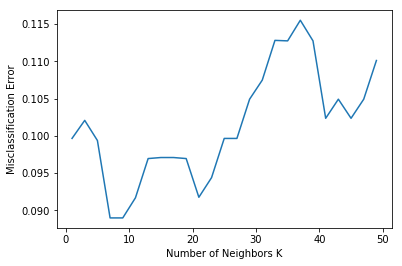

In [8]:
# Create odd list of K for KNN
k_list = list(range(1, 50))

# Subset just the odd ones
neighbors = filter(lambda x: x % 2 != 0, k_list)

# Empty list that will hold cv scores
cv_scores = []

# Perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# Change to misclassification error
MSE = [1 - x for x in cv_scores]

# Determine best k
optimal_k = neighbors[MSE.index(min(MSE))]
print 'Optimal number of neighbors: %d' % optimal_k

# Plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()    

## Predict with optimal k value

In [9]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

print('Accuracy score: %f' % accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy score: 0.968085
[[118   3]
 [  3  64]]
             precision    recall  f1-score   support

          B       0.98      0.98      0.98       121
          M       0.96      0.96      0.96        67

avg / total       0.97      0.97      0.97       188

